In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense,Dropout,Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
x_data = np.load('lip_x_data.npy') # x_save.npy
y_data = np.load('lip_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [3]:
print(y_data[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
print("x_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

x_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [5]:
class VGG_LSTM_fine(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(VGG_LSTM_fine, self).__init__()
        self.vgg = VGG16(weights='imagenet', include_top=False,
                         input_shape=(input_shape[2], input_shape[3], input_shape[4]))
        self.vgg.trainable = False

        set_trainable = False
        for layer in self.vgg.layers:
            if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3' or layer.name == 'block5_pool':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        self.vggDistributed = TimeDistributed(self.vgg)        
        self.bilstm = layers.Bidirectional(layers.LSTM(256), merge_mode='concat')
        self.dense = layers.Dense(num_classes, activation='softmax')
#         self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout = layers.Dropout(0.2)
        self.flat= TimeDistributed(Flatten())
        
    def call(self, x):
        x = self.vggDistributed(x)
        x = self.flat(x)
        x = self.dropout(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return x

In [7]:
def get_model_vgg_fine():
    return VGG_LSTM_fine(input_shape = (32, 27, 64, 64, 3), num_classes = 11)

In [8]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [10]:
model = get_model_vgg_fine()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=70, verbose = 1, validation_split = 0.2, callbacks = [es])

Epoch 1/70
60/60 [==============================] - 2314s 39s/step - loss: 2.4948 - accuracy: 0.0859 - val_loss: 2.3311 - val_accuracy: 0.1167
Epoch 2/70
60/60 [==============================] - 2304s 38s/step - loss: 2.3122 - accuracy: 0.1184 - val_loss: 2.3458 - val_accuracy: 0.0812
Epoch 3/70
60/60 [==============================] - 2309s 39s/step - loss: 2.2992 - accuracy: 0.1263 - val_loss: 2.3217 - val_accuracy: 0.1042
Epoch 4/70
60/60 [==============================] - 2316s 39s/step - loss: 2.2801 - accuracy: 0.1196 - val_loss: 2.3017 - val_accuracy: 0.1292
Epoch 5/70
60/60 [==============================] - 2305s 38s/step - loss: 2.2527 - accuracy: 0.1509 - val_loss: 2.3009 - val_accuracy: 0.1229
Epoch 6/70
60/60 [==============================] - 2283s 38s/step - loss: 2.1836 - accuracy: 0.1996 - val_loss: 2.3244 - val_accuracy: 0.1208
Epoch 7/70
60/60 [==============================] - 2283s 38s/step - loss: 2.1377 - accuracy: 0.2186 - val_loss: 2.2573 - val_accuracy: 0.1500

Epoch 58/70
60/60 [==============================] - 2279s 38s/step - loss: 0.1661 - accuracy: 0.9487 - val_loss: 1.3954 - val_accuracy: 0.6271
Epoch 59/70
60/60 [==============================] - 2281s 38s/step - loss: 0.1948 - accuracy: 0.9364 - val_loss: 1.2941 - val_accuracy: 0.6833


In [11]:
history.history

{'loss': [2.394479990005493,
  2.318490505218506,
  2.298175096511841,
  2.2757222652435303,
  2.2421090602874756,
  2.1727821826934814,
  2.118715763092041,
  2.0537140369415283,
  1.961403250694275,
  1.8136394023895264,
  1.71804678440094,
  1.6002949476242065,
  1.5161373615264893,
  1.452514410018921,
  1.3343173265457153,
  1.3354588747024536,
  1.2327371835708618,
  1.185186743736267,
  1.0645267963409424,
  1.0318048000335693,
  0.9929363131523132,
  0.9784649610519409,
  0.9289360642433167,
  0.8373563289642334,
  0.794704794883728,
  0.7539767622947693,
  0.7037937045097351,
  0.7141028642654419,
  0.6904078125953674,
  0.6383672952651978,
  0.5815674662590027,
  0.5651117563247681,
  0.5136757493019104,
  0.47140100598335266,
  0.4726288616657257,
  0.44949156045913696,
  0.40103814005851746,
  0.3674066364765167,
  0.3655311167240143,
  0.39505836367607117,
  0.33476722240448,
  0.3100394606590271,
  0.2996023893356323,
  0.3026215732097626,
  0.2452991008758545,
  0.261502

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


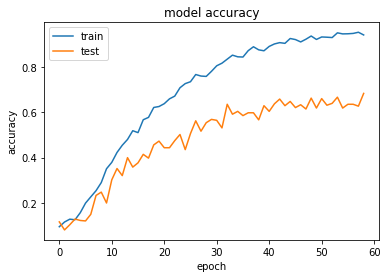

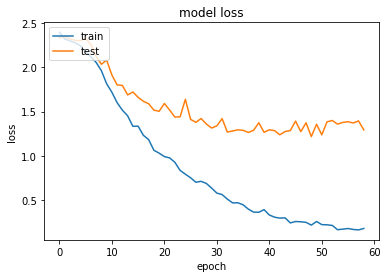

In [12]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
score = model.evaluate(X_test, Y_test, batch_size = 32, verbose = 1)
print("acc:", score[1], "loss:", score[0])

/Users/heegeepark/venv/myvenv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


19/19 [==============================] - 405s 21s/step - loss: 1.2085 - accuracy: 0.6800
acc: 0.6800000071525574 loss: 1.208500623703003


In [14]:
from tensorflow.keras.models import load_model

model.save_weights('finetuned_vgg_bilstm.h5')